## Prevendo a Popularidade das Músicas

### Importando os pacotes

In [1]:
import sys
sys.path.append(r'D:\\Estudos\\Codes\\spotify-best-songs\\src')

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import config, custom_funcs

sns.set_style('whitegrid')
sns.set_theme('notebook')
pd.set_option('display.precision',2)

### Importando os Dados

In [2]:
df = pd.read_csv(config.best_songs,sep=';')
df.head()

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96


In [3]:
# Observando se os nomes das colunas estão
# 

df.columns

Index(['title', 'artist', 'top genre', 'year', 'bpm', 'energy',
       'danceability ', 'dB', 'liveness', 'valence', 'duration',
       'acousticness', 'speechiness ', 'popularity'],
      dtype='object')

Visto que as colunas *'danceability'* e *'speechiness'* tem um espaço antes 

In [4]:
df.columns = df.columns.str.strip()

In [5]:
num_df = df.iloc[:,3:].copy()
num_df.head()

,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,2023,118,68,71,-4,3,65,200,6,7,98
1,2023,120,59,78,-8,35,73,174,44,3,97
2,2023,95,64,77,-7,17,53,195,74,14,96
3,2023,133,81,70,-8,25,86,131,25,5,96
4,2022,98,62,72,-6,8,17,222,42,5,96


In [6]:
X_train, X_test, y_train, y_test = train_test_split(num_df.iloc[:,:-1],num_df.iloc[:,-1],test_size=0.3,random_state=42)

In [7]:
train_data = X_train.join(y_train)

### Exploratory Data Analysis

In [8]:
train_data.describe()

,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
count,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00
mean,2011.10,120.02,69.81,67.04,-5.77,17.89,53.88,226.67,15.70,10.34,70.40
std,6.76,27.36,16.34,13.81,2.10,13.50,22.43,44.96,20.47,9.80,11.48
min,1985.00,60.00,11.00,18.00,-18.00,2.00,4.00,119.00,0.00,2.00,5.00
25%,2005.00,98.00,59.00,59.00,-7.00,9.00,37.00,200.00,2.00,4.00,64.00
50%,2011.00,120.00,72.00,68.00,-6.00,13.00,53.00,222.00,7.00,6.00,71.00
75%,2017.00,134.00,82.00,76.00,-4.00,23.00,72.00,247.00,22.00,13.00,78.00
max,2023.00,211.00,100.00,98.00,0.00,84.00,97.00,688.00,98.00,58.00,98.00


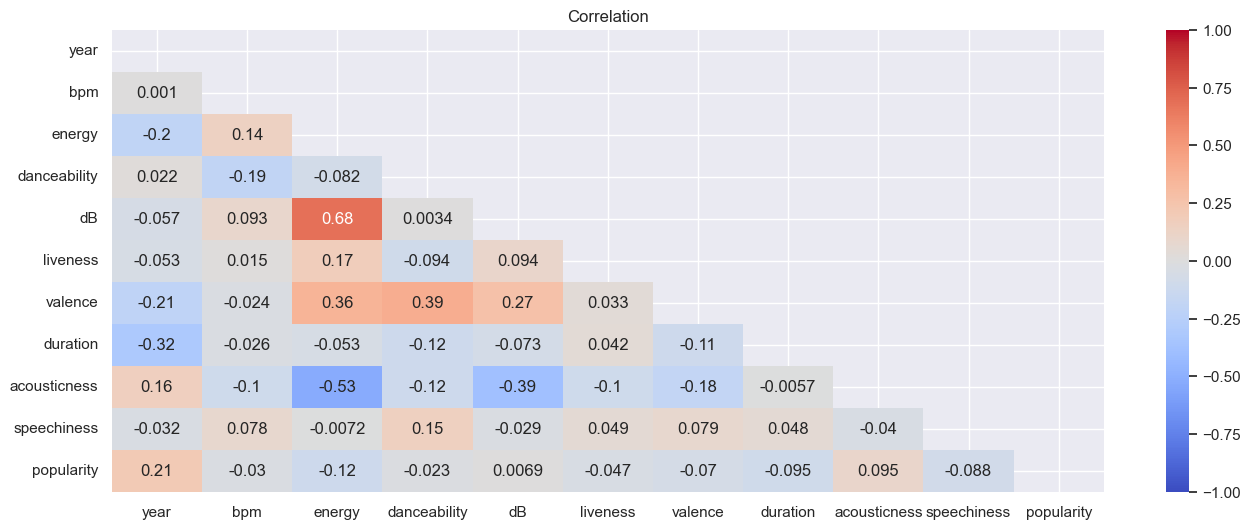

In [9]:
custom_funcs.corr_matrix(train_data)

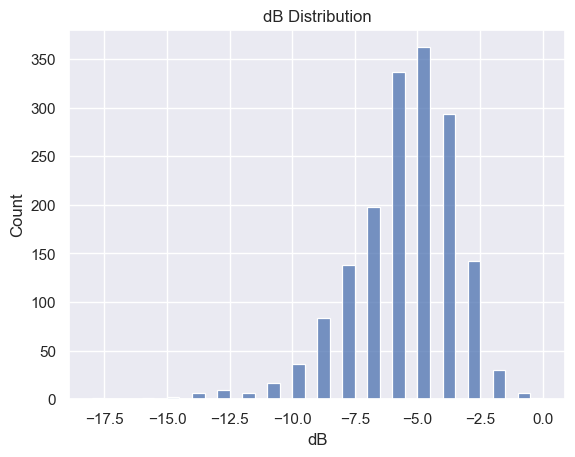

In [10]:
custom_funcs.histogram(train_data,'dB','dB Distribution')

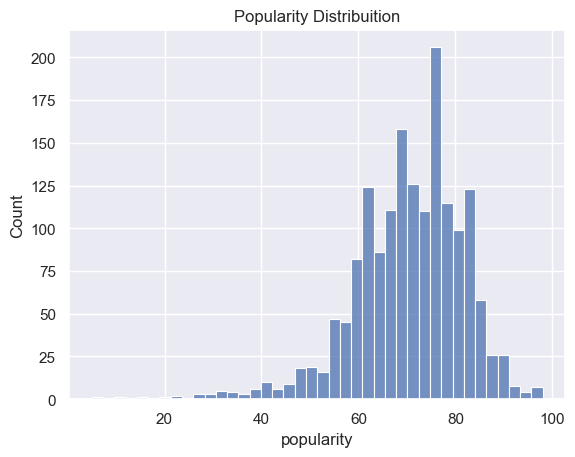

In [11]:
custom_funcs.histogram(train_data,'popularity','Popularity Distribuition')

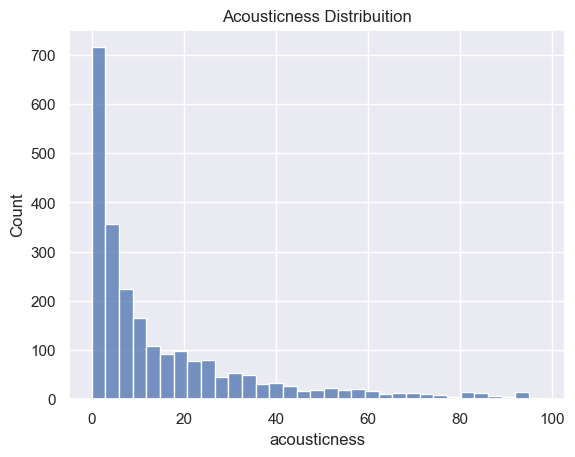

In [12]:
custom_funcs.histogram(df,'acousticness','Acousticness Distribuition')

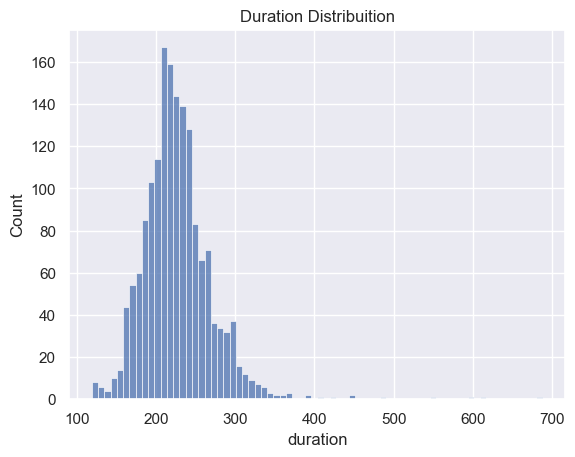

In [13]:
custom_funcs.histogram(train_data,'duration','Duration Distribuition')

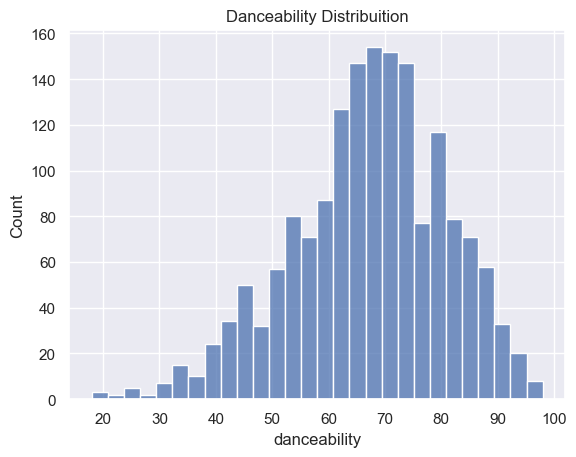

In [14]:
custom_funcs.histogram(train_data,'danceability','Danceability Distribuition')

Valence x Danceability


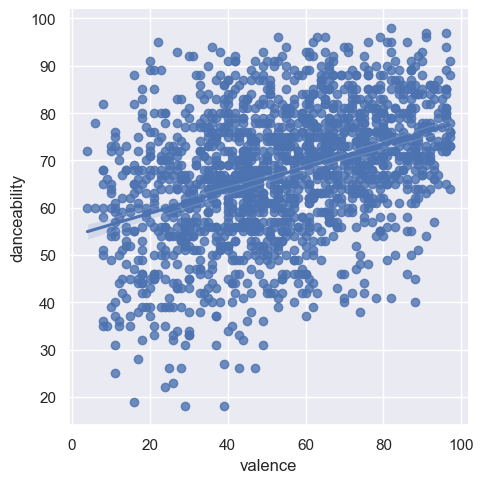

In [15]:
print('Valence x Danceability')
custom_funcs.comparative(train_data,'valence','danceability')

Valence x Energy


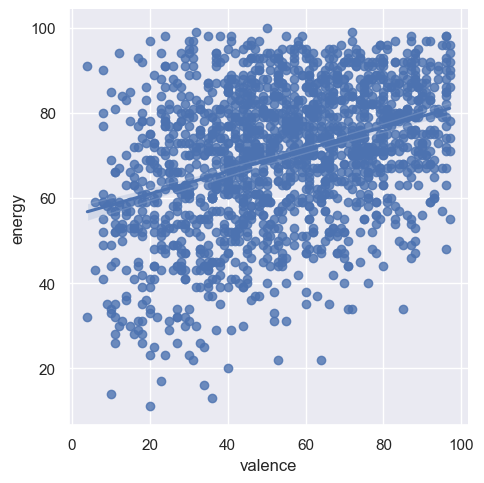

In [16]:
print('Valence x Energy')
custom_funcs.comparative(train_data,'valence','energy')

Popularity x Year


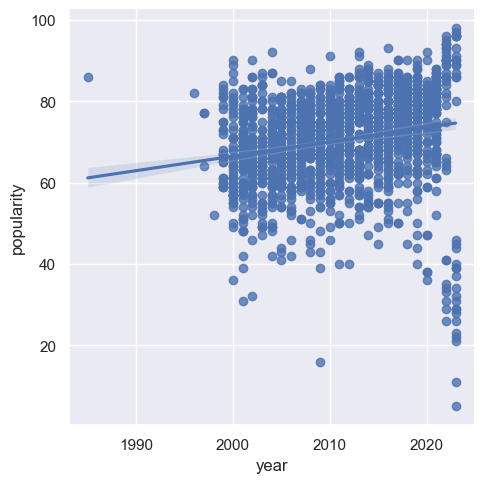

In [17]:
print('Popularity x Year')
_ = custom_funcs.comparative(train_data,'year','popularity')

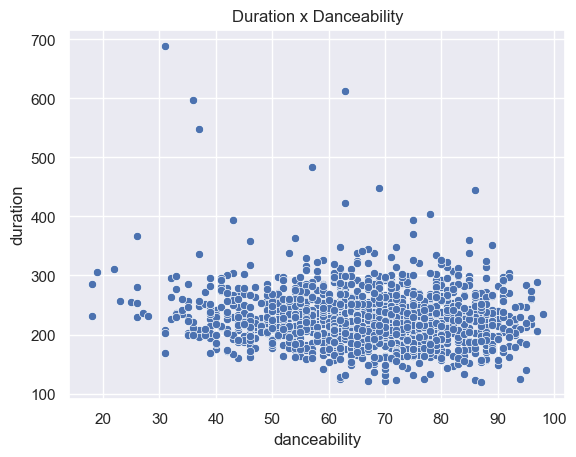

In [18]:
plt.title('Duration x Danceability')
_ = sns.scatterplot(data=train_data,x='danceability',y='duration')

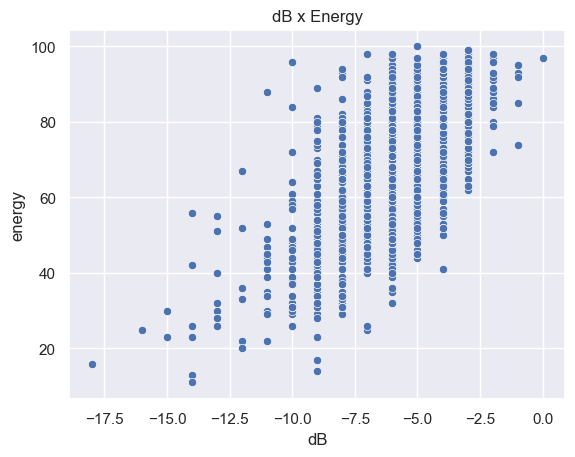

In [19]:
plt.title('dB x Energy')
_ = sns.scatterplot(data=train_data,x='dB',y='energy')

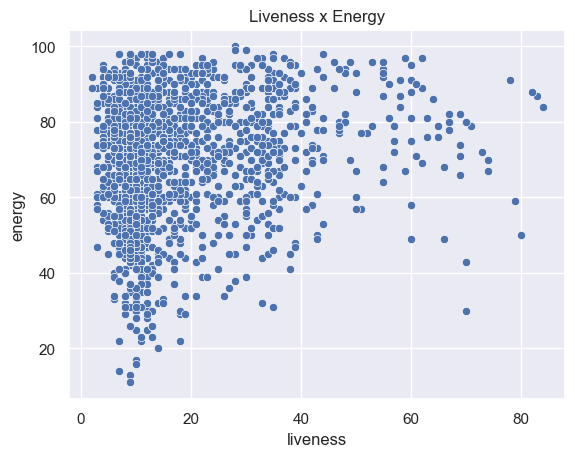

In [20]:
plt.title('Liveness x Energy')
_ = sns.scatterplot(data=train_data,x='liveness',y='energy')

### Preparing Data to Model

In [21]:
train_data.columns

Index(['year', 'bpm', 'energy', 'danceability', 'dB', 'liveness', 'valence',
       'duration', 'acousticness', 'speechiness', 'popularity'],
      dtype='object')

In [22]:
X_train.iloc[:,3]

686     76
2021    69
1359    51
305     78
209     68
        ..
1638    83
1095    31
1130    61
1294    55
860     79
Name: danceability, Length: 1669, dtype: int64

In [23]:
X_train.iloc[:,1]

686     127
2021    160
1359     84
305     103
209      90
       ... 
1638     69
1095    189
1130    128
1294    130
860     118
Name: bpm, Length: 1669, dtype: int64

In [24]:
X_train.iloc[:,0]

686     2010
2021    1999
1359    2015
305     2015
209     2021
        ... 
1638    2004
1095    2021
1130    2012
1294    2013
860     2016
Name: year, Length: 1669, dtype: int64

In [25]:
df['acousticness'].describe()

count    2385.00
mean       15.61
std        20.28
min         0.00
25%         2.00
50%         7.00
75%        22.00
max        98.00
Name: acousticness, dtype: float64

### Training Model

In [26]:
rf = RandomForestRegressor(random_state=42)

In [27]:
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [28]:
pred = rf.predict(X_test)

In [29]:
mean_absolute_error(y_test,pred).round(2)

8.32

### Saving Model

In [30]:
with open('reg.pkl','wb') as file:
    pickle.dump(rf,file)